In [ ]:
# see https://github.com/mmaelicke/scikit-gstat/tree/main/tutorials for details on using skgstat package

In [1]:
### set up the notebook
import skgstat as skg
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

/tmp/ipykernel_3029915/2551652185.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
### load the data

hourly_data = xr.open_dataset('./data/hourly_GNSS_ACCESS_ERA5_WTD.nc')

# save GNSS, ACCESS and ERA5 into seperate datasets and convert from meters to cm
GNSS = hourly_data.GNSS_buoy.values*100
ACCESS = hourly_data.ACCESS.values*100
ERA5 = hourly_data.ERA5.values*100

coords = np.genfromtxt('./data/buoy_locations_FSP_UTM.csv', delimiter=",")

In [4]:
### discard times without complete data (i.e. we want nine data points for every variogram, consistent between datasets)

# print shape
print("Shape of datasets before NaN removal: GNSS %s, ACCESS %s, ERA5 %s" % (np.shape(GNSS), np.shape(ACCESS), np.shape(ERA5)))

# print number of nans in each
print("Number of NaNs in each dataset: GNSS %s, ACCESS %s, ERA5 %s" % (len(GNSS[np.isnan(GNSS)]), len(ACCESS[np.isnan(ACCESS)]), len(ERA5[np.isnan(ERA5)])))

GNSS_full = []
ACCESS_full = []
ERA5_full = []

for i in range(len(GNSS[0,:])):
    gnss_row = GNSS[:,i]
    access_row = ACCESS[:,i]
    era5_row = ERA5[:,i]
    
    if len(gnss_row[np.isnan(gnss_row)]) == 0:
        if len(access_row[np.isnan(access_row)]) == 0:
            if len(era5_row[np.isnan(era5_row)]) == 0:
                GNSS_full.append(gnss_row)
                ACCESS_full.append(access_row)
                ERA5_full.append(era5_row)
                
GNSS_full = np.array(GNSS_full)
ACCESS_full = np.array(ACCESS_full)
ERA5_full = np.array(ERA5_full)

# print shape
print("\nShape of datasets after NaN removal: GNSS %s, ACCESS %s, ERA5 %s" % ((np.shape(GNSS_full), np.shape(ACCESS_full), np.shape(ERA5_full))))

# print number of nans in each
print("Check there are now zero nans: GNSS %s, ACCESS %s, ERA5 %s" % (len(GNSS_full[np.isnan(GNSS_full)]), len(ACCESS_full[np.isnan(ACCESS_full)]), len(ERA5_full[np.isnan(ERA5_full)])))    

Shape of datasets before NaN removal: GNSS (9, 2184), ACCESS (9, 2184), ERA5 (9, 2184)
Number of NaNs in each dataset: GNSS 1767, ACCESS 1593, ERA5 0

Shape of datasets after NaN removal: GNSS (1264, 9), ACCESS (1264, 9), ERA5 (1264, 9)
Check there are now zero nans: GNSS 0, ACCESS 0, ERA5 0


In [5]:
### calculate semivariograms for each

empirical_list_GNSS = []
empirical_list_ACCESS = []
empirical_list_ERA5 = []

n_lags = 10

for i in range(np.shape(GNSS_full)[0]):
    try:
        GNSS_vals = GNSS_full[i, :]
        ACCESS_vals = ACCESS_full[i, :]
        ERA5_vals = ERA5_full[i, :]
        
        GNSS_V = skg.Variogram(coords, GNSS_vals, n_lags=n_lags, normalize=False)
        ACCESS_V = skg.Variogram(coords, ACCESS_vals, n_lags=n_lags, normalize=False)
        ERA5_V = skg.Variogram(coords, ERA5_vals, n_lags=n_lags, normalize=False)
    
        empirical_list_GNSS.append(GNSS_V.get_empirical()[1])
        empirical_list_ACCESS.append(ACCESS_V.get_empirical()[1])
        empirical_list_ERA5.append(ERA5_V.get_empirical()[1])
    
    except:
        print('skipping ', i)
        continue

lag_list = GNSS_V.get_empirical()[0]

empirical_GNSS = np.array(empirical_list_GNSS)
empirical_ACCESS = np.array(empirical_list_ACCESS)
empirical_ERA5 = np.array(empirical_list_ERA5)

empirical_GNSS_mean = np.mean(empirical_GNSS, axis=0)
empirical_ACCESS_mean = np.mean(empirical_ACCESS, axis=0)
empirical_ERA5_mean = np.mean(empirical_ERA5, axis=0)

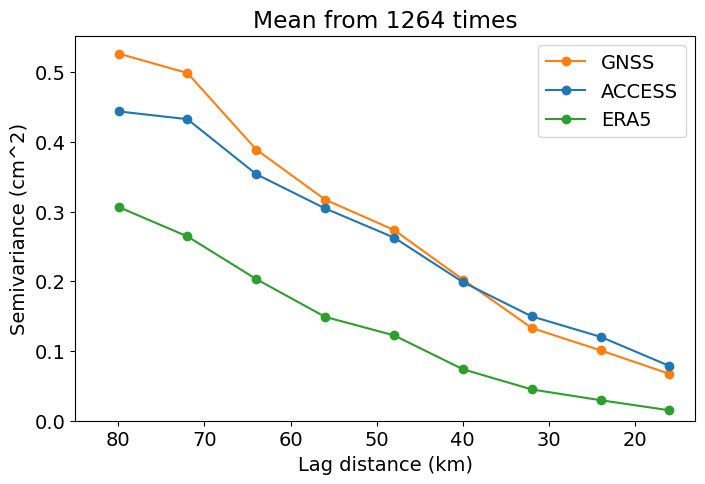

In [6]:
# plot the average variogram

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(lag_list/1000, empirical_GNSS_mean, c='C1', marker='o', label='GNSS')
ax.plot(lag_list/1000, empirical_ACCESS_mean, c='C0', marker='o', label='ACCESS')
ax.plot(lag_list/1000, empirical_ERA5_mean, c='C2', marker='o', label='ERA5')
ax.set_xlabel('Lag distance (km)')
ax.set_ylabel('Semivariance (cm^2)')
ax.set_title('Mean from 1264 times')
ax.set_ylim(0,None)
ax.set_xlim(85,13)
ax.legend()
plt.show()
